# Implicit Diffusion

In [22]:
# Import libraries
%matplotlib inline
from __future__ import division
import scipy.linalg as sp 
from scipy.sparse.linalg import spsolve
from scipy.sparse import diags
from scipy.sparse import csc_matrix
import numpy as np
import matplotlib.pylab as plt
import timeit

## Initial values

In [23]:
# Time-step, size and other inputs
dt = 0.01
N = 100

# Advection speed
v = 0.2

# Time of calculation
t_end = 2.25

#Spatial coordinate discretisation
x,dx = np.linspace(0,2,N,retstep=True)

# Pamameter beta
beta = 1.0/4.0*v*dt/dx

## Profiles

In [24]:
## Gaussian profile
def gaussian(x):
    mu = 1.0
    sig2 = 0.1
    return 1.0/(np.sqrt(2.*np.pi*sig2))*np.exp(-np.power(x - mu, 2.)/(2.0*sig2))

## Box profile
def box_prof(x):
    #Really slow masking
    u = np.ones_like(x)
    x_mask = np.where([(el > 0.5) and (el < 1) for el in x])
    u[x_mask] = 2.0
    return u

def box_profile(x):
    #Much better masking
    u = np.ones_like(x)
    ubound = np.where(x >= 0.5)
    lbound = np.where(x <= 1)
    u[np.intersect1d(lbound,ubound)] = 2.0
    
    return u

#%timeit box_prof(x)
#%timeit box_profile(x)

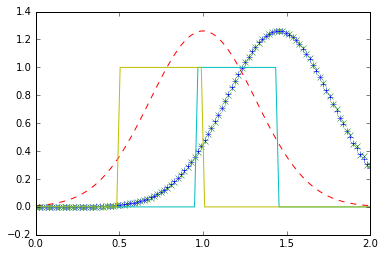

In [27]:
## Matrix initiation
matrix = csc_matrix(diags([-beta, 1, beta], [-1, 0, 1], shape=(N-2, N-2)).toarray())

## Initial gaussian and box profile
u1 = gaussian(x)
u2 = box_profile(x)

## Right sides
def R_solutions(u,N):

    R = np.empty(N-2)
    R[0] = u[1]-beta*(u[2]-u[0])+beta*u[0]
    R[N-3] = u[N-2]-beta*(u[N-1]-u[N-3])-beta*u[N-1]

    R[1:N-3] = u[2:N-2]-beta*(u[3:N-1]-u[1:N-3])
   
    return R

## Running profile
def run(t_end,N):
    t = 0.0
    u = u1.copy()
    while t < t_end:
        ##rs = R_solutions(u,N)
        u[1:N-1] = spsolve(matrix,R_solutions(u,N))
        
        # Boundary condition
        u[N-1] = u[N-2] # Free outflow
        u[0] = 0.       # Zero inflow

        t += dt
    return u,t


u_res,t = run(t_end,N)

# Srovnani numerickeho a exaktniho reseni
plt.plot(x,u1,'r--')
plt.plot(x,u_res,'gx')
plt.plot(x,gaussian(x-v*t_end),'b+')
plt.plot(x,box_prof(x-v*t_end)-1,'c-')
plt.plot(x,u2-1,'y-')